In [2]:
import random
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [4]:
# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'ml-club-kyiv'
!gcloud config set project {project_id}

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud alpha survey



In [5]:
!gsutil cp gs://ml-club-meetup-01/data/flats.json flats.json

Copying gs://ml-club-meetup-01/data/flats.json...
| [1 files][ 10.4 MiB/ 10.4 MiB]                                                
Operation completed over 1 objects/10.4 MiB.                                     


In [6]:
with open('flats.json', 'r') as f:
  text = f.read()
  records = json.loads(text)
print(records[:10])

[{'district': ['Саперна Слобідка', 'Голосіївський'], 'short_description': 'Шикарная квартира, после дизайнерского ремонта 2019 года с использованием экологически чистых материалов, видовая - 19 этаж, Площадь - 140 кв.м. (один уровень), большая гостинная - 30 кв.м, две спальни, большой холл, 2 санузла, 2 гардероба. Импортная мебель, вся бытовая техника, кондиционирование. Закрытый двор, охрана, парковка. Без комиссионных.', 'attributes': [['3-кімнатна', '140 / 71 / 19 м²', '19 поверх з 21'], ['спец. проект', '2008 р', 'монолітно-каркасний']], 'image': None, 'street': 'вул. Саперно-Слобідська', 'price': '190 000 $'}, {'district': ['Соцмісто', 'Дніпровський'], 'short_description': 'Продается 2 комнатная квартира в Днепровском районе, массив Соцгородок, ул. Красноткацкая 18. Квартира на 2 этаже 5 этажного дома. Площадь квартиры 45/30/8 кв.м.. Санузел раздельный. Квартира ухоженная, в жилом состоянии. Комната светлая и просторная. В квартире есть мебель и необходимая бытовая техника. Устано

In [7]:
def parse_price(price_text):
  parts = price_text.split(' ')
  price = ''.join(parts[0:-1])
  currency = parts[-1]
  return (int(price), currency)

In [8]:
RATES = {
    '$': 1,
    'грн': 0.042,
    '€': 1.10,
}
def convert_currency(row):
  if row['currency'] in RATES:
    return RATES[row['currency']] * row['price']

  return None

In [9]:
def assign_attributes(max_attributes, attributes, checks):
    result = [None] * max_attributes
    attr_num = len(attributes)
    last_position = 0

    for attribute_idx in range(0, attr_num):
        lookup_start = max(attribute_idx, last_position)
        lookup_end = max_attributes - (attr_num - attribute_idx)
        for position_idx in range(lookup_start, lookup_end + 1):
            if checks[position_idx](attributes[attribute_idx]):
                result[position_idx] = attributes[attribute_idx]
                last_position = position_idx
                break

    return result

In [10]:
MAX_ATTR_NUM = 3

rooms_values = set({})
area_values = set({})
floor_values = set({})

room_area_floor_checks = [
    lambda x: x in rooms_values or 'кімнатна' in x,
    lambda x: x in area_values or 'м²' in x,
    lambda x: x in floor_values or 'поверх' in x,
]

project_values = set({})
year_values = set({})
technology_values = set({})

project_year_technology_checks = [
    lambda x: x in project_values,
    lambda x: x in year_values or x.endswith(' р'),
    lambda x: x in technology_values,
]

for record in records:
  if len(record['attributes'][0]) == MAX_ATTR_NUM:
    rooms_values.add(record['attributes'][0][0])
    area_values.add(record['attributes'][0][1])
    floor_values.add(record['attributes'][0][2])
  if len(record['attributes'][1]) == MAX_ATTR_NUM:
    project_values.add(record['attributes'][1][0])
    year_values.add(record['attributes'][1][1])
    technology_values.add(record['attributes'][1][2])

def detect_attributes(attributes):
  rooms, area, floor = assign_attributes(MAX_ATTR_NUM, attributes[0], room_area_floor_checks)
  project, year, technology = assign_attributes(MAX_ATTR_NUM, attributes[1], project_year_technology_checks)
  return {
      'rooms': rooms,
      'area': area,
      'floor': floor,
      'project': project,
      'year': year,
      'technology': technology
  }

print (detect_attributes([['3-кімнатна', '140 / 71 / 19 м²', '19 поверх з 21'], ['спец. проект', '2008 р', 'монолітно-каркасний']]))

{'rooms': '3-кімнатна', 'area': '140 / 71 / 19 м²', 'floor': '19 поверх з 21', 'project': 'спец. проект', 'year': '2008 р', 'technology': 'монолітно-каркасний'}


In [11]:
def parse_num_rooms(rooms_info):
  if rooms_info is None:
    return None
  if rooms_info == 'однокімнатна':
    return 1
  if rooms_info.endswith('-кімнатна'):
    return int(rooms_info.split('-')[0])
    
  raise 'Unexpected value {}'.format(rooms_info)

In [12]:
flat_records = []
for record in records:
  price, currency = parse_price(record['price'])
  attributes = detect_attributes(record['attributes'])
  flat_record = {
      'district': record['district'][-1],
      'micro_district': record['district'][-2] if len(record['district']) > 1 else None,
      'price': price,
      'currency': currency,
      'num_rooms': parse_num_rooms(attributes['rooms']),
      'total_area': None if attributes['area'] is None else attributes['area'].replace('м²', '').split('/')[0].strip(),
      'floor': None if attributes['floor'] is None else attributes['floor'].split(' ')[0],
      'project': attributes['project'],
      'year': None if attributes['year'] is None else attributes['year'].split(' ')[0],
      'technology': attributes['technology']
  }
  flat_records.append(flat_record)

In [13]:
df = pd.DataFrame(flat_records)

In [14]:
df['currency'].unique()

array(['$', 'грн', '€'], dtype=object)

In [15]:
df['price_usd'] = df.apply(lambda row: convert_currency(row), axis=1)
df['new_building'] = df.apply(lambda row: row['year'] == 'новобудова', axis=1)
df['year'].replace('новобудова', '', inplace=True)
df.fillna('', inplace=True)

In [16]:
df.head()

,currency,district,floor,micro_district,num_rooms,price,project,technology,total_area,year,price_usd,new_building
0,$,Голосіївський,19,Саперна Слобідка,3,190000,спец. проект,монолітно-каркасний,140,2008,190000.0,False
1,$,Дніпровський,2,Соцмісто,2,49000,хрущовка,панель,45,,49000.0,False
2,$,Дніпровський,8,Микільська Слобідка,1,49000,,,51,,49000.0,False
3,$,Подільський,13,Вітряні Гори,2,70000,спец. проект,утеплена панель,64,2015,70000.0,False
4,$,Дніпровський,11,Північно-Броварський (Комсомольський),2,58500,БПС,панель,45,1975,58500.0,False


### `Prepare data for Linear regression`

Select only Area, Num Rooms, Floor and Price. Remove null values


In [17]:
selected_data = df[['total_area', 'num_rooms', 'floor', 'year', 'price_usd']]
selected_data = selected_data[(selected_data['total_area'].astype(str).str.isdigit()) & 
                              (selected_data['num_rooms'].notnull()) & 
                              (selected_data['num_rooms'].astype(str).str.len() > 0) & 
                              (selected_data['floor'].astype(str).str.isdigit())&
                              (selected_data['year'].astype(str).str.isdigit())]

Shuffle

In [18]:
selected_data = selected_data.sample(frac=1).reset_index(drop=True)

Dataset info

In [19]:
selected_data.head()

,total_area,num_rooms,floor,year,price_usd
0,55,2,4,1984,48000.0
1,89,3,12,1900,75000.0
2,41,1,25,2015,57000.0
3,190,4,3,2011,210000.0
4,68,2,2,1974,56000.0


In [20]:
selected_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2122 entries, 0 to 2121
Data columns (total 5 columns):
total_area    2122 non-null object
num_rooms     2122 non-null object
floor         2122 non-null object
year          2122 non-null object
price_usd     2122 non-null float64
dtypes: float64(1), object(4)
memory usage: 83.0+ KB


To float

In [21]:
selected_data = selected_data.astype(float)

Remove anomaly values

In [22]:
selected_data = selected_data[selected_data['total_area'] < 500]
selected_data = selected_data[selected_data['price_usd'] < 1000000]

Convert values to float and normalize

In [23]:
def normalize(d_frame):
    norm_dict = {}
    result = d_frame.copy()
    for feature_name in d_frame.columns:
        max_value = d_frame[feature_name].max()
        min_value = d_frame[feature_name].min()
        norm_dict[feature_name] = (min_value, (max_value - min_value))
        result[feature_name] = (d_frame[feature_name] - min_value) / (max_value - min_value)

    return result, norm_dict

In [24]:
selected_data, norm_dict = normalize(selected_data)

Split train and test data

In [25]:
TEST_DATASET_SIZE = 200

In [26]:
selected_data_train = selected_data[:selected_data.shape[0]-TEST_DATASET_SIZE]
selected_data_test = selected_data[selected_data.shape[0]-TEST_DATASET_SIZE:]

### Prepare dataset

In [27]:
def create_X_y(src_df):
  data = src_df.to_numpy()
  X = data[:,:(data.shape[1]-1)]

  ones = np.ones([X.shape[0],1])
  X = np.concatenate((ones,X),axis=1)

  y = data[:,(data.shape[1]-1)].reshape(-1,1)
  return X, y

In [28]:
def denorm_data_array(data_array, norm_tuple):
  return (data_array*norm_tuple[1]) + norm_tuple[0]

### Define Linear regression functions

In [29]:
def calculate_cost(theta,X,y):
    '''
    
    Calculates the cost for given X and Y. The following shows and example of a single dimensional X
    theta = Vector of thetas 
    X     = Row of X's np.zeros((2,j))
    y     = Actual y's np.zeros((2,1))
    
    where:
        j is the no of features
    '''
    
    m = len(y)
    
    predictions = X.dot(theta)
    cost = (1/2*m) * np.sum(np.square(predictions-y))
    return cost

In [30]:
def gradient_descent(X,y,theta,learning_rate=0.01,iterations=100):
    '''
    X    = Matrix of X with added bias units
    y    = Vector of Y
    theta=Vector of thetas np.random.randn(j,1)
    learning_rate 
    iterations = no of iterations
    
    Returns the final theta vector and array of cost history over no of iterations
    '''
    m = len(y)
    cost_history = np.zeros(iterations)
    theta_history = np.zeros((iterations,X.shape[1]))
    for it in range(iterations):
        
        prediction = np.dot(X,theta)
        
        theta = theta -(1/m)*learning_rate*( X.T.dot((prediction - y)))
        theta_history[it,:] =theta.T
        cost_history[it]  = calculate_cost(theta,X,y)
        
    return theta, cost_history, theta_history

### Define analize functions

In [31]:
def plot_cost_history(num_iterations, cost_history):
    fig, ax = plt.subplots(figsize=(8,8))

    ax.set_ylabel('J(Theta)')
    ax.set_xlabel('Iterations')
    _=ax.plot(range(num_iterations),cost_history,'b.')

In [32]:
def plot_weights(X, y, theta_history, num_steps):
    fig, ax = plt.subplots(figsize=(8,8))
    _=ax.plot(X[:,1],y,'b.')

    step = int(theta_history.shape[0]/num_steps)
    for i in range(num_steps):
      y_pred = theta_history[i*step][0] + theta_history[i*step][1]* X[:,1] #the line equation
      plt.plot(X[:,1], y_pred, c='g')
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)

In [33]:
def predict(theta, X_test, norm_tuple_for_y):
  result = np.array(X_test).dot(theta)
  return denorm_data_array(result, norm_tuple_for_y)

In [34]:
def show_comparsion(comparsion_df):
  comparsion_df_head = comparsion_df.head(25)
  comparsion_df_head.plot(kind='bar',figsize=(16,10))
  plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
  plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
  plt.show()

## `Linear regression with 1 variable`

In [35]:
selected_data_1_variable = selected_data_train[['total_area', 'price_usd']]

Remove anomaly high values

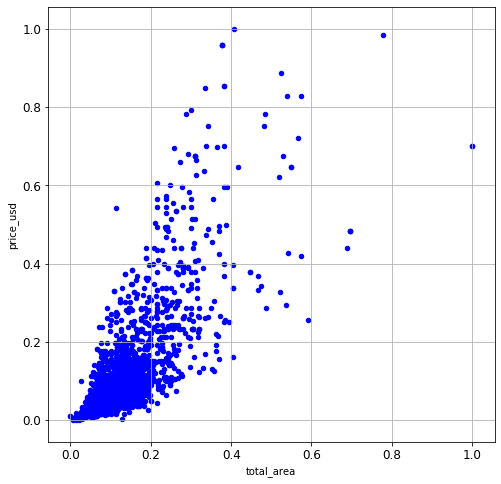

In [36]:
selected_data_1_variable.plot(kind='scatter',    x='total_area',    y='price_usd',    figsize=(8,8),    grid = True,    fontsize = 12,    c='b')

In [37]:
learning_rate = 0.1
num_iterations = 5000

theta = [[.0], [.1]]

X, y = create_X_y(selected_data_1_variable)

theta, cost_history, theta_history = gradient_descent(X,y,theta,learning_rate,num_iterations)

print('Theta0:          {:0.3f},\nTheta1:          {:0.3f}'.format(theta[0][0],theta[1][0]))
print('Final cost/MSE:  {:0.3f}'.format(cost_history[-1]))

Theta0:          -0.030,
Theta1:          1.118
Final cost/MSE:  15767.151


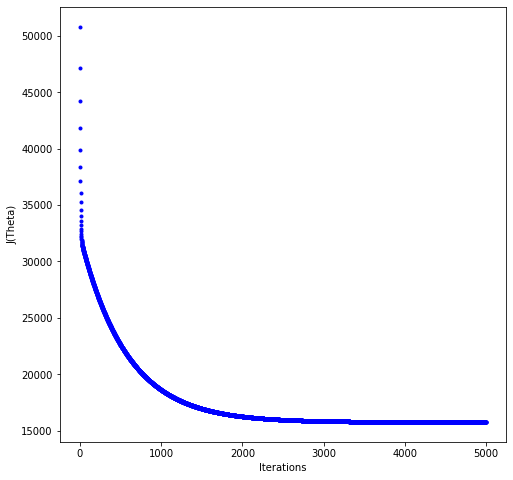

In [38]:
plot_cost_history(num_iterations, cost_history)

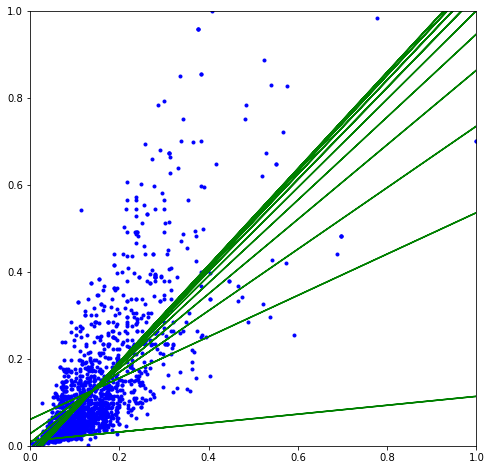

In [39]:
plot_weights(X, y, theta_history, 10)

### Predicted price for 50 m^2

In [40]:
x = 50
norm_tuple_for_x = norm_dict['total_area']
norm_tuple_for_y = norm_dict['price_usd']
norm_x = (x - norm_tuple_for_x[0])/norm_tuple_for_x[1]
norm_x = [1, norm_x]

results_denormalized = predict(theta, norm_x, norm_tuple_for_y)
print(results_denormalized[0])

71211.51143266173


### Predictions for test dataset

In [41]:
selected_data_1_variable_test = selected_data_test[['total_area', 'price_usd']]
X_test, y_test = create_X_y(selected_data_1_variable_test)

In [42]:
y_test_predicted = predict(theta, X_test, norm_tuple_for_y)
y_test_actual = denorm_data_array(y_test, norm_tuple_for_y)

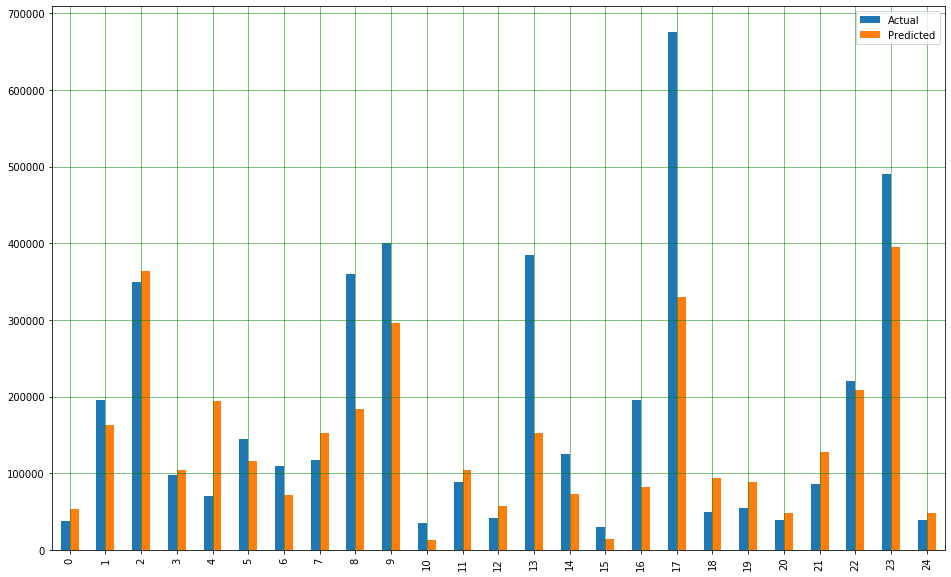

In [43]:
predicted_test_comparsion = pd.DataFrame({'Actual': y_test_actual.flatten(), 'Predicted': y_test_predicted.flatten()})
predicted_test_comparsion = predicted_test_comparsion.astype(int)
show_comparsion(predicted_test_comparsion)

In [46]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_actual, y_test_predicted))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_actual, y_test_predicted))  

Mean Absolute Error: 60874.34296754517
Mean Squared Error: 8068306549.488672


## `Linear regression with multiple variable`

In [47]:
learning_rate = 0.1
num_iterations = 100000

theta = np.random.randn(selected_data_train.shape[1],1)

X, y = create_X_y(selected_data_train)

theta, cost_history, theta_history = gradient_descent(X,y,theta,learning_rate,num_iterations)

print('Theta: {}'.format(theta))
print('Final cost/MSE:  {:0.3f}'.format(cost_history[-1]))

Theta: [[-0.02445152]
 [ 1.22508043]
 [-0.069862  ]
 [-0.00342538]
 [-0.00349645]]
Final cost/MSE:  15644.699


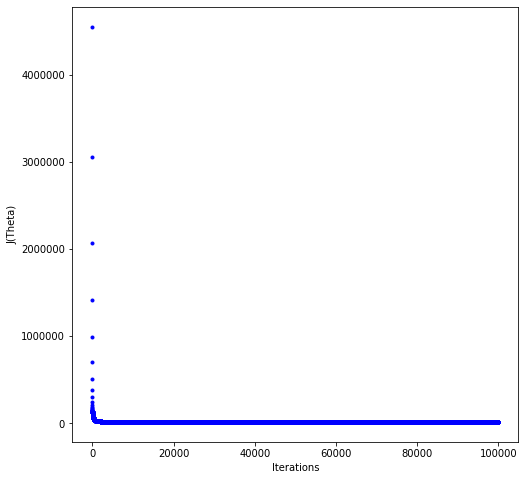

In [48]:
plot_cost_history(num_iterations, cost_history)

### Predicted price for 50 m^2

In [49]:
x = [50, 2, 10, 1980]
norm_x = []
for column in range(len(selected_data.columns)-1):
  norm_tuple_for_x = norm_dict[selected_data.columns[column]]
  norm_x.append((x[column] - norm_tuple_for_x[0])/norm_tuple_for_x[1])

norm_x.insert(0, 1)

results_denormalized = predict(theta, norm_x, norm_tuple_for_y)
print(results_denormalized[0])

69506.63951214823


###Predictions for test dataset

In [50]:
X_test, y_test = create_X_y(selected_data_test)

In [51]:
y_test_predicted = predict(theta, X_test, norm_tuple_for_y)
y_test_actual = denorm_data_array(y_test, norm_tuple_for_y)

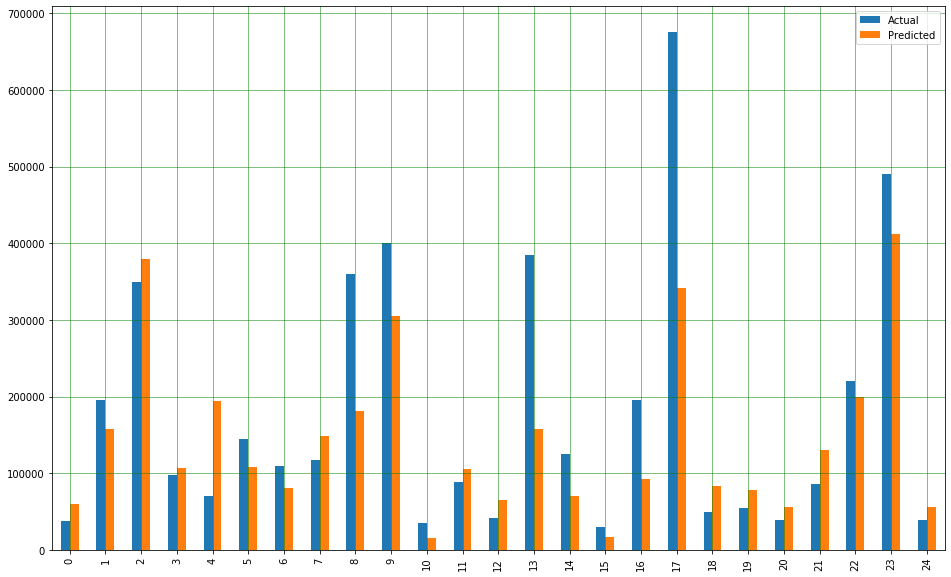

In [52]:
predicted_test_comparsion = pd.DataFrame({'Actual': y_test_actual.flatten(), 'Predicted': y_test_predicted.flatten()})
predicted_test_comparsion = predicted_test_comparsion.astype(int)
show_comparsion(predicted_test_comparsion)

In [53]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_actual, y_test_predicted))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_actual, y_test_predicted))  

Mean Absolute Error: 59640.43535205968
Mean Squared Error: 7884286130.133331


# Linear Regression with SKLEARN

In [54]:
X, y = create_X_y(selected_data_train)

In [55]:
regressor = LinearRegression()  
regressor.fit(X, y) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [56]:
theta = regressor.coef_
theta[0][0] = regressor.intercept_[0]
theta = theta.reshape(-1,1)
print(theta)

[[-0.02445152]
 [ 1.22508043]
 [-0.069862  ]
 [-0.00342538]
 [-0.00349645]]


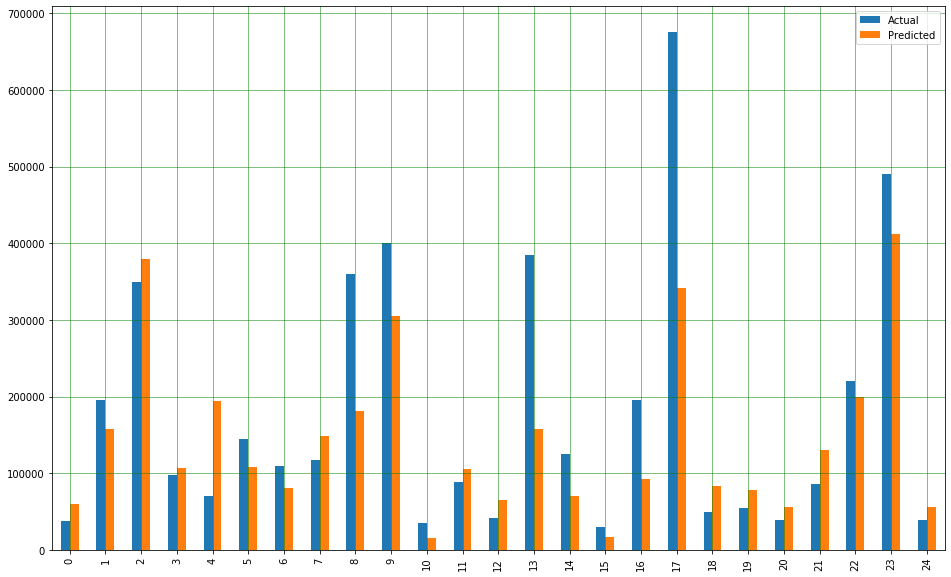

In [57]:
X_test, y_test = create_X_y(selected_data_test)

y_test_predicted = predict(theta, X_test, norm_tuple_for_y)
y_test_actual = denorm_data_array(y_test, norm_tuple_for_y)

predicted_test_comparsion = pd.DataFrame({'Actual': y_test_actual.flatten(), 'Predicted': y_test_predicted.flatten()})
predicted_test_comparsion = predicted_test_comparsion.astype(int)
show_comparsion(predicted_test_comparsion)

In [58]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_actual, y_test_predicted))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_actual, y_test_predicted))  

Mean Absolute Error: 59640.43535205828
Mean Squared Error: 7884286130.133167
